In [7]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
data_path = os.environ['SIERRA_DATA_PATH']
results_path = os.environ['SIERRA_RESULTS_PATH']
sns.set_style('whitegrid')

In [9]:
ff_locations = {
    'merced': 'IFR at Shaffer Bridge'
}

In [103]:
DISCHARGE = 'Discharge'
IFR = 'IFR'
IFR_SPILL = 'IFR Spill'
FNF = 'FNF'
STORAGE = 'Storage'
BASELINE_STORAGE = 'Baseline storage'
BASELINE_FLOW = 'Baseline flow'
colors = {
    IFR: 'red',
    DISCHARGE: 'blue',
    FNF: 'grey',
    IFR_SPILL: 'orange',
    BASELINE_STORAGE: 'green',
    STORAGE: 'blue',
    BASELINE_FLOW: 'green'
}

In [87]:
root_scenario = 'Functional Flows'
scenario_names = [d for d in os.listdir(results_path) if d.split(' - ')[0] == root_scenario]
scenario_name = scenario_names[-1] if scenario_names else None
if not scenario_name:
    raise Exception('Scenario "{}" not found'.format(root_scenario))
    
run_date = scenario_name.split(' - ')[-1]

In [88]:
scenario_path = os.path.join(results_path, scenario_name)
basins = os.listdir(scenario_path)
print(basins)

['merced']


In [89]:
basin = basins[0]
historical_path = os.path.join(scenario_path, basin, 'historical', 'Livneh')

# load fnf
basin_full = basin.replace('_', ' ').title() + ' River'
fnf_path = os.path.join(data_path, basin_full, 'hydrology/historical/Livneh/preprocessed/full_natural_flow_daily_mcm.csv')
fnf = pd.read_csv(fnf_path, index_col=0, parse_dates=True) / 0.0864 * 35.315
fnf.columns = [FNF]
fnf.head()

,FNF
date,
1950-01-01,93.953573
1950-01-02,231.059347
1950-01-03,70.366229
1950-01-04,76.462015
1950-01-05,90.748368


In [90]:
ff_location = ff_locations[basin]
ensemble_name = root_scenario # This needn't be the case

def load_location_data(variable, location, ensemble_name=None):
    csv_path = os.path.join(historical_path, '{}_{}.csv'.format(variable, run_date))
    df = pd.read_csv(csv_path, header=[0,1], index_col=0, parse_dates=True)
    df = df[location]
    if ensemble_name:
        df = df[ensemble_name].to_frame()
    return df

# Load data and plot plots
(hint: "Run All Below" after re-running model)

In [98]:
# load functional flow IFR
ifr_df = load_location_data('InstreamFlowRequirement_Min Flow_mcm', ff_location, ensemble_name) / 0.0864 * 35.315
ifr_df.columns = [IFR]

# load IFR simulated flow
flow_df = load_location_data('InstreamFlowRequirement_Flow_mcm', ff_location, ensemble_name) / 0.0864 * 35.315
flow_df.columns = [DISCHARGE]

# load baseline flow
flow_baseline_df = load_location_data('InstreamFlowRequirement_Flow_mcm', ff_location, 'baseline') / 0.0864 * 35.315 + 1
flow_baseline_df.columns = [BASELINE_FLOW]

flows_df = pd.concat([fnf.loc[ifr_df.index], ifr_df, flow_df, flow_baseline_df], axis=1)
flows_df[IFR_SPILL] = flows_df[DISCHARGE] - flows_df[IFR]
flows_df.head()

,FNF,IFR,Discharge,Baseline flow,IFR Spill
Date,,,,,
1960-10-01,32.579769,32.579769,32.579769,1.0,-4.973799e-14
1960-10-02,32.818867,32.818867,32.818867,1.0,0.000000e+00
1960-10-03,32.524548,32.524548,32.524548,1.0,0.000000e+00
1960-10-04,32.511934,32.511934,32.511934,1.0,0.000000e+00
1960-10-05,142.654633,40.000000,40.000000,1.0,0.000000e+00


In [99]:
# load simulated storage - convert to TAF (double-check conversion!!)
storage_df = load_location_data('Reservoir_Storage_mcm', 'Lake McClure', ensemble_name) / 1.2335
storage_df.columns = [STORAGE]
baseline_storage_df = load_location_data('Reservoir_Storage_mcm', 'Lake McClure', 'baseline') / 1.2335
baseline_storage_df.columns = [BASELINE_STORAGE]
storage_df = pd.concat([storage_df, baseline_storage_df], axis=1)
storage_df.head()

,Storage,Baseline storage
Date,,
1960-10-01,606.724808,606.789427
1960-10-02,605.381557,605.511270
1960-10-03,603.979645,604.173868
1960-10-04,602.702706,602.961414
1960-10-05,601.637027,601.975072


In [100]:
def plot_timeseries(df, ylabel='', start=None, end=None, yscale='linear', title=None, ymax=None, ymin=None):
    fig, axes = plt.subplots(figsize=(15, 5))
    ax = axes
    if start and end:
        df_plot = df.loc[start:end]
    else:
        df_plot = df
        
    # create the plot
    for col in df_plot:
        ax.plot(df_plot.index, df_plot[col].values, color=colors.get(col, 'black'), label=col)
        
    # tweak plot
    ax.set_yscale(yscale)
    scale_label = '[{} scale]'.format(yscale) if yscale != 'linear' else ''
    ylabel += (' ' if ylabel else '') + scale_label
    if ylabel:
        ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    if ymin is not None and ymax is not None:
        ax.set_ylim(ymin, ymax)
    elif ymax:
        ax.set_ylim(0, ymax)
        
    plt.legend()
    
    plt.show()

## Full time series

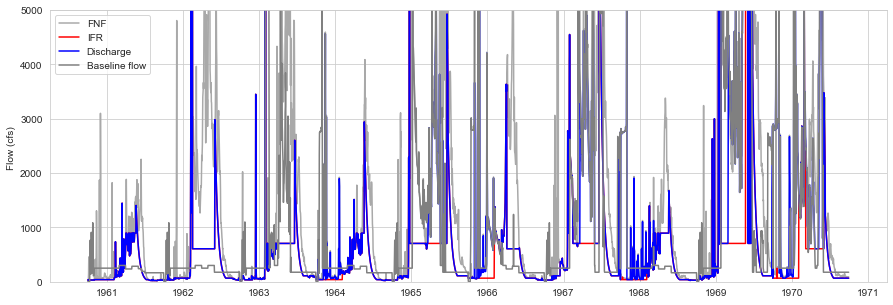

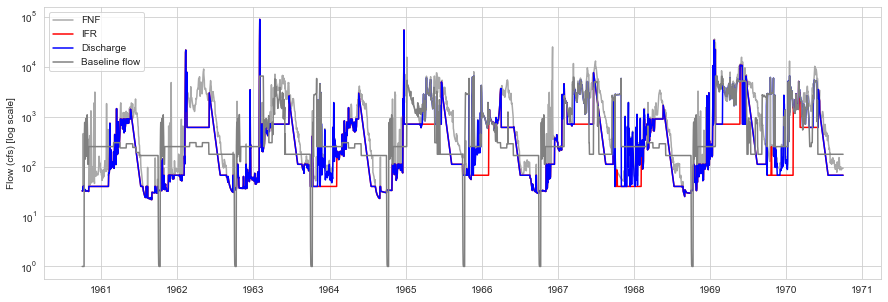

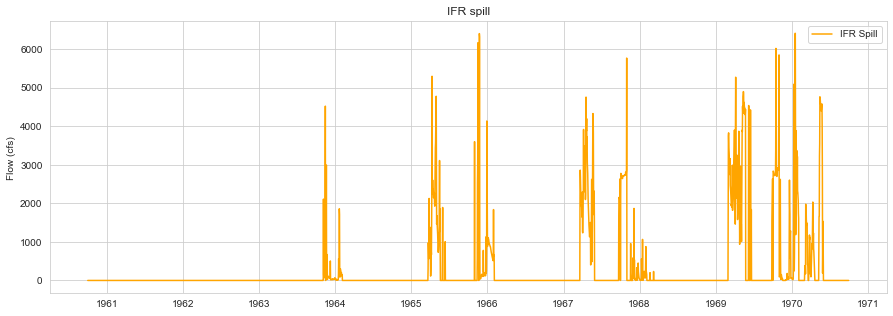

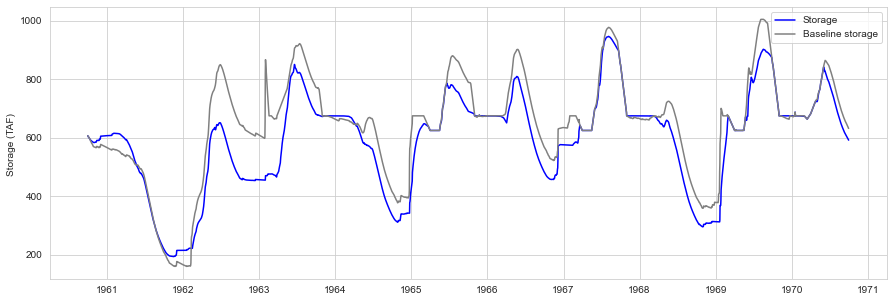

In [101]:
def plot_flow_timeseries(*args, **kwargs):
    plot_timeseries(*args, ylabel='Flow (cfs)', **kwargs)

# plot FNF, IFR and simulated discharge
plot_flow_timeseries(flows_df[[FNF, IFR, DISCHARGE, BASELINE_FLOW]], ymax=5000)
plot_flow_timeseries(flows_df[[FNF, IFR, DISCHARGE, BASELINE_FLOW]], ymin=10, yscale='log')
# plot_flow_timeseries(flows_df[[IFR, DISCHARGE]], yscale='log')

# plot difference between IFR and discharge
plot_flow_timeseries(flows_df[[IFR_SPILL]], title='IFR spill')

plot_timeseries(storage_df, ylabel='Storage (TAF)')

## Subset of years

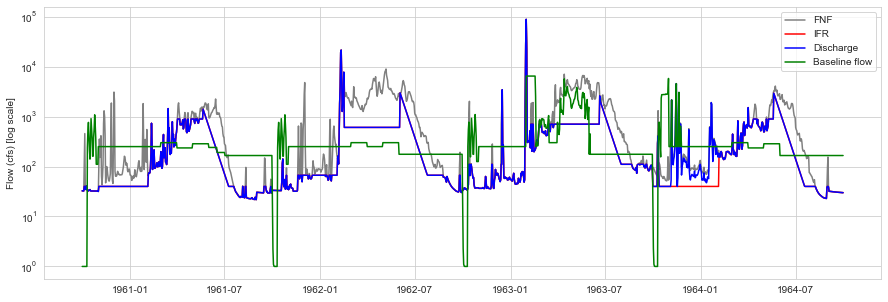

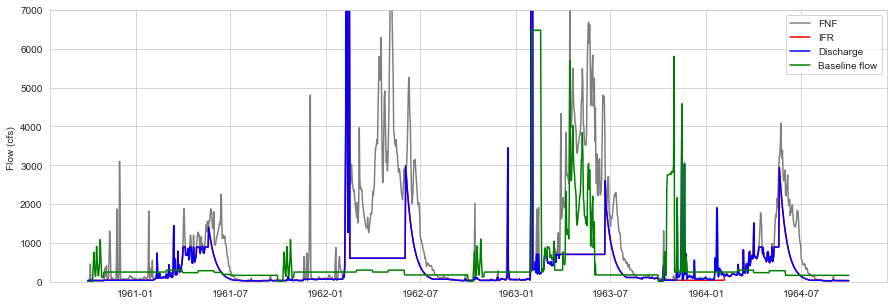

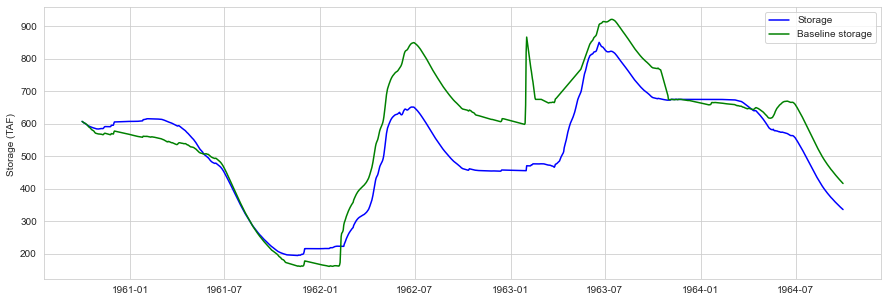

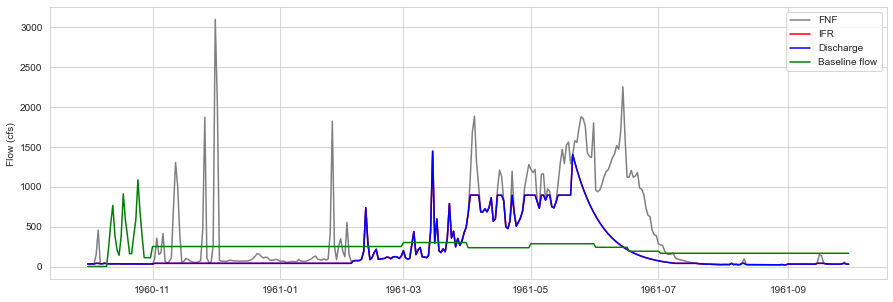

In [106]:
main_columns = [FNF, IFR, DISCHARGE, BASELINE_FLOW]
plot_flow_timeseries(flows_df[main_columns], start='1960-10-01', end='1964-09-30', yscale='log')
plot_flow_timeseries(flows_df[main_columns], start='1960-10-01', end='1964-09-30', ymax=7000)
plot_timeseries(storage_df, start='1960-10-01', end='1964-09-30', ylabel='Storage (TAF)')
plot_flow_timeseries(flows_df[main_columns], start='1960-10-01', end='1961-09-30')